In [2]:
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorboard
import tensorflow as tf
import matplotlib.pyplot as plt


In [3]:
def create_weights(vectors_ref:pd.DataFrame , word_dict:dict):
    rows = len(word_dict) +1
    columns = len(vectors_ref.columns)
    shape = (rows , columns)
    weights = np.zeros(shape=shape)
    inx = list(set(vectors_ref.index) & set(list(word_dict.values())))
    vectors_ref = vectors_ref.loc[inx]
    for key in word_dict.keys():
        try:
            weights[key] = vectors_ref.loc[word_dict[key]]
        except:
            pass
    return weights




def create_model(maxlen , weights , input_dim , output_dim = 100):
    model = Sequential()
    model.add(layers.Input((maxlen,)))
    model.add(layers.Embedding(input_dim= input_dim , output_dim=100 , input_length= maxlen , weights = [weights],trainable = False))
    model.add(layers.Conv1D(128,5)) 
    model.add(layers.MaxPool1D(pool_size=2))
    model.add(layers.LSTM(32, activation='relu'))
    model.add(layers.Dense(1 ,activation ="sigmoid"))

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(1e-3,decay_rate=0.9999,decay_steps=1000)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                metrics=['accuracy'])

    return model


In [4]:
glove = pd.read_csv("glove.6B.100d.txt",header=None , delimiter=" " ,quoting=csv.QUOTE_NONE, encoding='utf-8')
glove.set_index(0 , drop= True,inplace=True)

In [5]:
df = pd.read_csv("processed_regex_stem.csv")


In [6]:
X_data,  y_data = df["processed"] , df["labels"]

In [7]:
X, X_validation, y, y_validation = train_test_split(X_data, y_data, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [8]:
tokenizer = Tokenizer(oov_token = "<oov>", lower= True)
tokenizer.fit_on_texts(X_train)

In [9]:
input_dim = len(tokenizer.index_word) +1
longest_sentence_length = X_train.apply(lambda x : len(x.split())).max()
# average_sentence_length = X_train.apply(lambda x : len(x.split())).mean()
X_train.apply(lambda x : len(x.split())).describe()

count    578.000000
mean     195.434256
std      126.793026
min        8.000000
25%      112.000000
50%      167.000000
75%      237.750000
max      881.000000
Name: processed, dtype: float64

In [10]:
len_of_sents = X_train.apply(lambda x : len(x.split()))

In [11]:
sum(len_of_sents < 300) / len(len_of_sents)

0.842560553633218

In [12]:
maxlen = 150

In [13]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_validation = tokenizer.texts_to_sequences(X_validation)

In [14]:
X_train = pad_sequences(X_train, maxlen= maxlen , padding= "post")
X_test = pad_sequences(X_test, maxlen= maxlen , padding= "post")
X_validation = pad_sequences(X_validation, maxlen= maxlen , padding= "post")

In [15]:
weights = create_weights(glove , tokenizer.index_word)

In [16]:
weights.shape

(6465, 100)

In [17]:
model = create_model(maxlen=maxlen , input_dim= input_dim , weights=weights )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 100)          646500    
                                                                 
 conv1d (Conv1D)             (None, 146, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 73, 128)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 731,269
Trainable params: 84,769
Non-trainable params: 646,500
_____________________________________________

In [18]:


log_dir = "logs_lag_1\\" + datetime.now().strftime("%d-%m-%Y_%H%M%S")
checkpoint_path = "hybrid_model_weights/cp.ckpt"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
      monitor="accuracy",
      min_delta=1e-3,
      patience=15,
      verbose=1,
      restore_best_weights=True,
    )


check_point_cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(x = X_train , y = y_train,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    batch_size=32,
                    callbacks=[early_stopping_cb,check_point_cb,tensorboard_callback])

Epoch 1/10
18/19 [===========================>..] - ETA: 0s - loss: 0.6989 - accuracy: 0.5052
Epoch 00001: saving model to hybrid_model_weights\cp.ckpt
19/19 [==============================] - 7s 187ms/step - loss: 0.6984 - accuracy: 0.5069 - val_loss: 0.7357 - val_accuracy: 0.4615
Epoch 2/10
18/19 [===========================>..] - ETA: 0s - loss: 0.6648 - accuracy: 0.5747
Epoch 00002: saving model to hybrid_model_weights\cp.ckpt
19/19 [==============================] - 3s 135ms/step - loss: 0.6649 - accuracy: 0.5744 - val_loss: 0.7106 - val_accuracy: 0.4000
Epoch 3/10
19/19 [==============================] - ETA: 0s - loss: 0.6296 - accuracy: 0.6678
Epoch 00003: saving model to hybrid_model_weights\cp.ckpt
19/19 [==============================] - 3s 146ms/step - loss: 0.6296 - accuracy: 0.6678 - val_loss: 0.7259 - val_accuracy: 0.5077
Epoch 4/10
18/19 [===========================>..] - ETA: 0s - loss: 0.5673 - accuracy: 0.6892
Epoch 00004: saving model to hybrid_model_weights\cp.ckpt

In [19]:
model.save('model_hybrid')

INFO:tensorflow:Assets written to: model_hybrid\assets


In [20]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

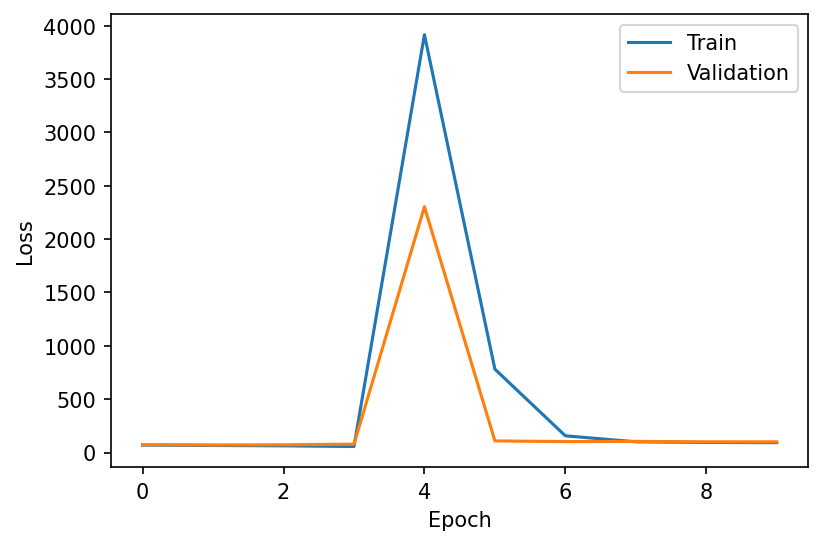

In [21]:
plt.figure(dpi=150 )
plt.plot([100*loss for loss in train_loss] ,label = "Train")
plt.plot([100*loss for loss in val_loss] , label = "Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

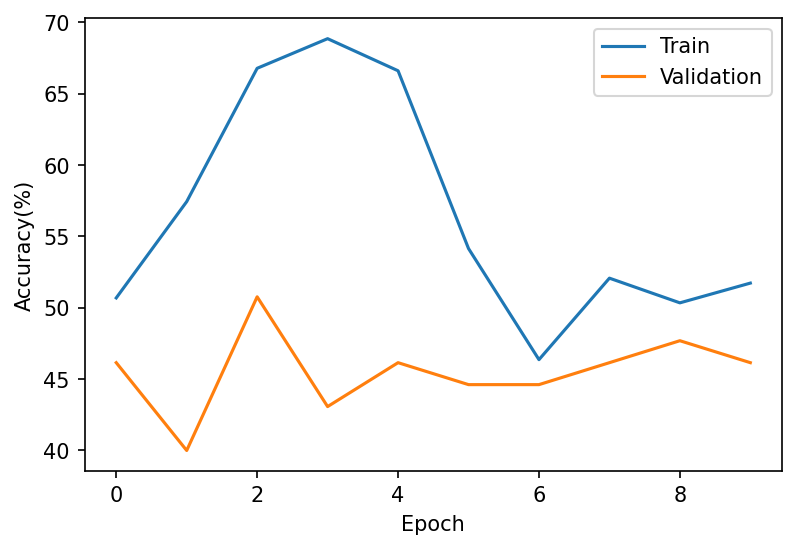

In [22]:
plt.figure(dpi=150 )
plt.plot([100*acc for acc in train_accuracy] ,label = "Train")
plt.plot([100*acc for acc in val_accuracy] , label = "Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy(%)")
plt.legend()

In [28]:
model = tf.keras.models.load_model('model_hybrid')

In [29]:
Y_pred_prob = model.predict(X_validation)

In [30]:
Y_pred = np.apply_along_axis(lambda x : 1 if x>0.5 else 0,1,Y_pred_prob  )

In [31]:
confusion_matrix(y_validation,Y_pred )

array([[30, 47],
       [31, 53]], dtype=int64)

In [32]:
print(classification_report(y_validation,Y_pred ))

              precision    recall  f1-score   support

           0       0.49      0.39      0.43        77
           1       0.53      0.63      0.58        84

    accuracy                           0.52       161
   macro avg       0.51      0.51      0.51       161
weighted avg       0.51      0.52      0.51       161

